# Optimization Techniques in Machine Learning

Objective: This assignment aims to explore implementation or Machine Learning Models with regularization, optimization and Error analysis  techniques used in machine learning to improve models' performance, convergence speed, and efficiency..

A Notebook detailing the following

* Project name
* Clear out puts from cells






**Instructions**

1. Acquire a dataset suitable for ML tasks as per your proposal.
2. Implement a simple machine learning model based on neural networks on the chosen dataset without any defined optimization techniques. (Check instructions)
3. Implement and compare the model's performance after applying 3 to 4 disntict combinations regularization and optimization techniques.
4. Discuss the results on the README file.
5. Make predictions using test data
7. Implement error analysis techniques and ensure there is: F1-Score, Recall, Precision, RUC a confusion matrix using plotting libraries (not verbose)

Submit notebook to github repo




# Case Study and Implementation




In [32]:
#Import Necessary Libraries
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns



In [33]:
def load_csv_data(url):
  data = pd.read_csv(url, sep=';')
  data = pd.DataFrame(data)
  return data

In [34]:
# function to rename columns during cleaning
def rename_column(df, old_col_name, new_col_name):
  df.rename(columns= {old_col_name :  new_col_name}, inplace=True)

In [35]:
# function for preprocessing involving encoding and scaling
def preprocessing(df, nom_col, ord_col, num_col, target_column_string):
    df_encoded = df.copy()

    # Smart encoding of nominal columns
    for col in nom_col:
        unique_count = df[col].nunique()
        # OHE for columns with less than 10 categories
        if unique_count <= 10:
            dummies = pd.get_dummies(df[col], prefix=col, drop_first=True)
            df_encoded = pd.concat([df_encoded, dummies], axis=1)
            df_encoded.drop(columns=col, inplace=True)
        # frequency encoding for features between 10 and 30 columns
        elif 10 < unique_count <= 30:
            freq_map = df[col].value_counts().to_dict()
            df_encoded[f'{col}_freq'] = df[col].map(freq_map)
            df_encoded.drop(columns=col, inplace=True)
        # Group rare + frequency encoding for features with 30+ categories
        else:
            col_temp = df[col].where(df[col].isin(df[col].value_counts().head(10).index), 'Other')
            freq_map = col_temp.value_counts().to_dict()
            df_encoded[f'{col}_freq'] = col_temp.map(freq_map)
            df_encoded.drop(columns=col, inplace=True)

    # Ordinal encoding
    ordinal_encoder = OrdinalEncoder()
    df_encoded[ord_col] = ordinal_encoder.fit_transform(df_encoded[ord_col])

    # Label encoding for target variable
    # label_encoder = LabelEncoder()
    # label_encoder.fit(['Graduate', 'Dropout'])  # dropout becomes 1
    # df_encoded[target_column_string] = label_encoder.transform(df_encoded[target_column_string])
    df_encoded[target_column_string] = df_encoded[target_column_string].map({'Dropout': 1, 'Graduate': 0})


    # Numerical scaling
    standard_scaler = StandardScaler()
    df_encoded[num_col] = standard_scaler.fit_transform(df_encoded[num_col])

    return df_encoded, standard_scaler, ordinal_encoder

In [36]:
# function for quickly checking for the shape, NaN values and duplicated values
def quick_inspect(df):
  duplicated_sum = df.duplicated().sum()
  nan_values = df.isna().sum().sum()
  input_shape = df.shape
  if duplicated_sum > 0:
    print(f"Number of duplicates: {duplicated_sum}")
  else:
    print(f'There are no duplicates in the data set')

  if nan_values > 0:
    print(f'The number of NaN Values are: {nan_values}')
  else:
    print(f'There are no NaN values in the dataset ')
  print(f'The number of rows in the data are {df.shape[0]}, and the number of columns are {df.shape[1]}')

In [37]:
# Random forest builder function
def random_forest_model(X_train,X_test, y_train, y_test, X_val, y_val):
    rf = RandomForestClassifier(

        # Tuned hyperparameters

        n_estimators=300,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf= 1,
        max_features= 'log2',
        random_state=42,
        # class_weight='balanced'
    )

    rf.fit(X_train, y_train)


    # Validation set evaluation
    y_val_pred = rf.predict(X_val)
    print("Validation Performance:")
    print('=====Validation Report=====')
    print(classification_report(y_val, y_val_pred))
    print('\n')

    # Predict and evaluate on test set
    y_pred = rf.predict(X_test)
    print('=====Test Report=====')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    y_pred_proba = rf.predict_proba(X_test)

      # For multiclass ROC-AUC
    if len(np.unique(y_test)) > 2:
      roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    else:
      roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

    # Loss (not applicable for sklearn RF, use validation score instead)
    loss = 1 - accuracy  # Simple approximation

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Loss: {loss:.4f}")
    print(f"F1-score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    return rf

# The Dataset
***Brief Description:***

**Problem Statement:**
University dropout is a critical challenge in higher education systems globally, with significant implications for both individual students and institutional outcomes. Current predictive approaches often rely on static
demographic data or simplistic models that fail to capture the complex, nonlinear relationships between academic performance, socioeconomic factors, and behavioral patterns that influence student attrition. Many existing systems lack early detection capabilities and struggle with the temporal dynamics of student data, resulting in delayed interventions when support strategies could be most effective. This project addresses the need for a comprehensive, machine learning-based early warning system that can accurately predict student dropout risk by integrating  data and capturing complex feature interactions to enable timely, data-driven interventions.

**Dataset Description:**
The "Predict Students' Dropout and Academic Success" dataset contains information from a higher education institution with 4,424 student records across 36 features. The dataset encompasses students enrolled in diverse undergraduate programs including agronomy, design, education, nursing, journalism, management, social service, and technologies. Each instance represents a student with comprehensive information available at enrollment time, including academic path details, demographic characteristics, and socioeconomic factors, as well as academic performance data from the first and second semesters. The target variable is formulated as a three-category classification task (dropout, enrolled, graduate), with a notable class imbalance favoring one category. The target variable will be reduced to two categories - "Graduated" and "Dropout" as we are more interested in predicting dropouts from students who are not presently attending("Enrolled") in the institution. The dataset has undergone rigorous preprocessing to handle anomalies, outliers, and missing values, making it suitable for machine learning applications focused on early identification of at-risk students.


In [68]:
#TO DO: Load Data (Seprate into: Train, Validation and test sets)
import os
print(os.path.exists('/content/oie_wDdlIZv5mG5x.png'))

True


#SECTION 1: Model Architecture:



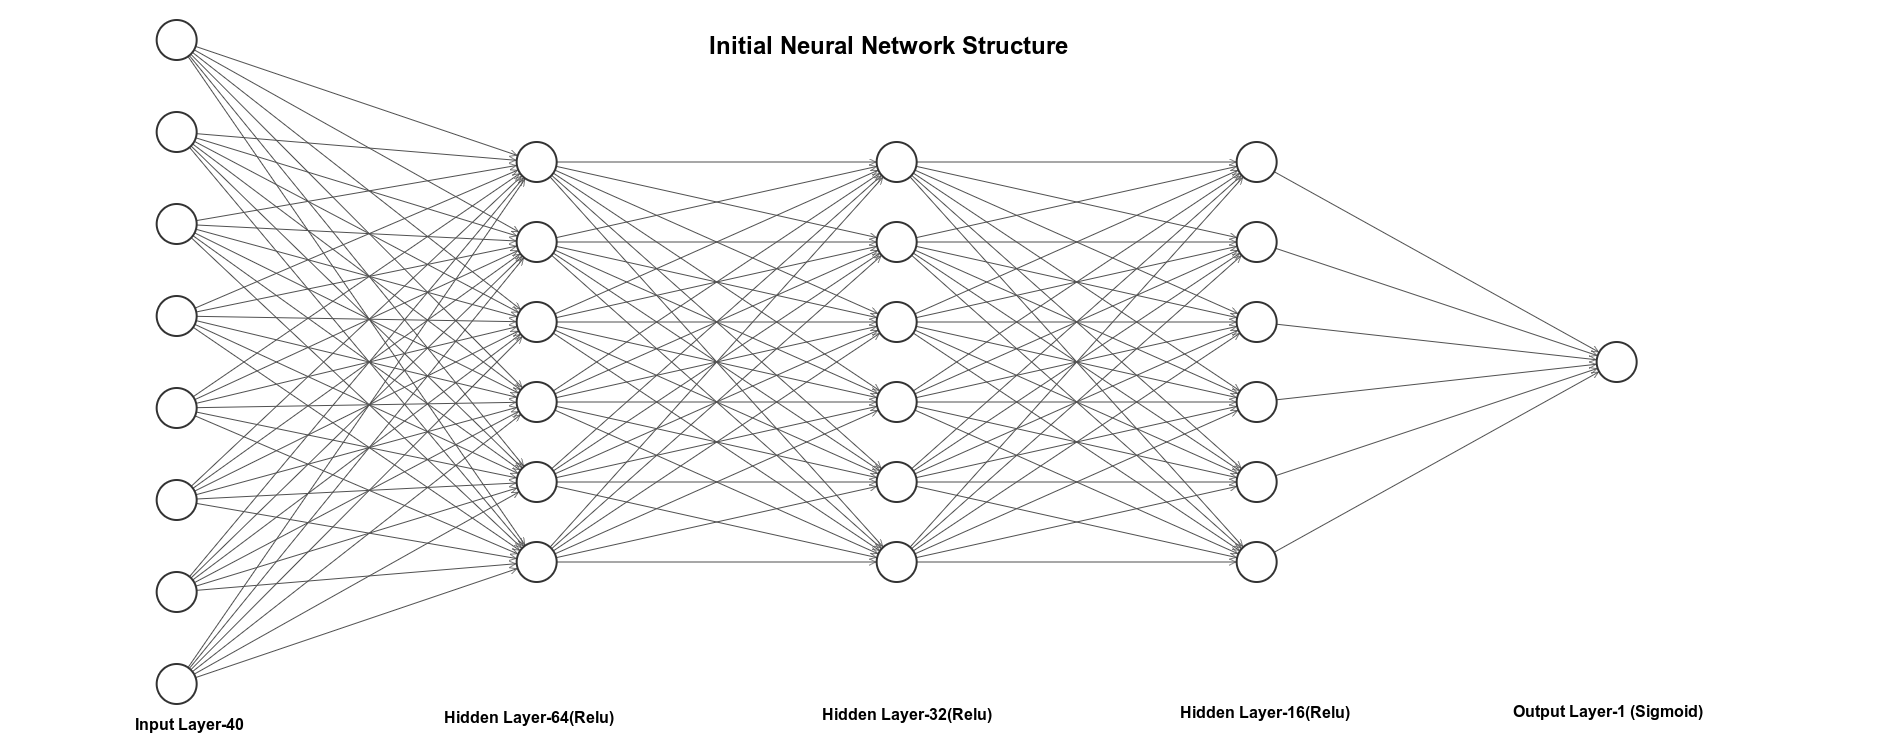

In [69]:
from IPython.display import Image, display
display(Image('/content/oie_wDdlIZv5mG5x.png'))

#Task: Define a function that creates models without and With specified Optimization techniques


In [38]:
#TO DO: Load Data (Seprate into: Train, Validation and test sets)
# Load Data
url = 'dropout_data.csv'
data = load_csv_data(url)

# quickly checking for the shape, NaN values and duplicated values
quick_inspect(data)

There are no duplicates in the data set
There are no NaN values in the dataset 
The number of rows in the data are 4424, and the number of columns are 37


In [39]:
# Check for values in the target variable
data['Target'].value_counts(normalize=True)
data.head()

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


In [41]:
# Start Data cleaning
data.head()
# rename Nacionality column
data = data.copy()
rename_column(data,'Nacionality', 'Nationality')
rename_column(data,'daytime/evening_attendance\t', 'daytime_or_evening_attendance')

# Convert to lowercase all columns
for i in data:
  rename_column(data, i, i.lower())

# Remove apostrophes and replace spaces with underscores
data.columns = data.columns.str.replace("'", "").str.replace(" ", "_").str.replace('(', "").str.replace(')', "")
data.columns



Index(['marital_status', 'application_mode', 'application_order', 'course',
       'daytime_or_evening_attendance', 'previous_qualification',
       'previous_qualification_grade', 'nationality', 'mothers_qualification',
       'fathers_qualification', 'mothers_occupation', 'fathers_occupation',
       'admission_grade', 'displaced', 'educational_special_needs', 'debtor',
       'tuition_fees_up_to_date', 'gender', 'scholarship_holder',
       'age_at_enrollment', 'international',
       'curricular_units_1st_sem_credited',
       'curricular_units_1st_sem_enrolled',
       'curricular_units_1st_sem_evaluations',
       'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade',
       'curricular_units_1st_sem_without_evaluations',
       'curricular_units_2nd_sem_credited',
       'curricular_units_2nd_sem_enrolled',
       'curricular_units_2nd_sem_evaluations',
       'curricular_units_2nd_sem_approved', 'curricular_units_2nd_sem_grade',
       'curricular_units_2nd_sem_

In [42]:
# Drop rows that have 'Enrolled' as a target variable because students who are currently enrolled do not contribute any info for graduating or dropping out.
data = data.drop(data[data['target'] == 'Enrolled'].index)

In [43]:
# Start Data Preprocessing
numerical_columns = [
    'previous_qualification_grade',
    'admission_grade',
    'curricular_units_1st_sem_credited',
    'curricular_units_1st_sem_enrolled',
    'curricular_units_1st_sem_evaluations',
    'curricular_units_1st_sem_approved',
    'curricular_units_1st_sem_grade',
    'curricular_units_1st_sem_without_evaluations',
    'curricular_units_2nd_sem_credited',
    'curricular_units_2nd_sem_enrolled',
    'curricular_units_2nd_sem_evaluations',
    'curricular_units_2nd_sem_approved',
    'curricular_units_2nd_sem_grade',
    'curricular_units_2nd_sem_without_evaluations',
    'unemployment_rate',
    'inflation_rate',
    'gdp',
    'age_at_enrollment'
]

nominal_columns = [
    'marital_status',
    'application_mode',
    'course',
    'daytime_or_evening_attendance',
    'previous_qualification',
    'nationality',
    'mothers_qualification',
    'fathers_qualification',
    'mothers_occupation',
    'fathers_occupation',
    'displaced',
    'educational_special_needs',
    'debtor',
    'tuition_fees_up_to_date',
    'gender',
    'scholarship_holder',
    'international'
]
ordinal_columns = [
    'application_order'
]

nom_col_data = data[nominal_columns]

# nom_col_data.nunique()

data_encoded, standard_scaler, ordinal_encoder = preprocessing(data, nominal_columns, ordinal_columns, numerical_columns, 'target')

data_encoded.head()


,application_order,previous_qualification_grade,admission_grade,age_at_enrollment,curricular_units_1st_sem_credited,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_evaluations,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,...,fathers_qualification_freq,mothers_occupation_freq,fathers_occupation_freq,displaced_1,educational_special_needs_1,debtor_1,tuition_fees_up_to_date_1,gender_1,scholarship_holder_1,international_1
0,5.0,-0.825034,0.000415,-0.442212,-0.304517,-2.465538,-1.883107,-1.480034,-2.083224,-0.189871,...,34,436,847,True,False,False,True,True,False,False
1,1.0,2.045805,1.040849,-0.569976,-0.304517,-0.131288,-0.483214,0.373306,0.685217,-0.189871,...,220,272,321,True,False,False,False,True,False,False
2,5.0,-0.825034,-0.170709,-0.569976,-0.304517,-0.131288,-1.883107,-1.480034,-2.083224,-0.189871,...,1010,1313,847,True,False,False,False,True,False,False
3,2.0,-0.825034,-0.526647,-0.442212,-0.304517,-0.131288,-0.016583,0.373306,0.572219,-0.189871,...,1010,436,321,True,False,False,True,False,False,False
4,1.0,-2.487099,0.972400,2.751894,-0.304517,-0.131288,0.216733,0.064416,0.355641,-0.189871,...,575,1313,847,False,False,False,True,False,False,False


In [44]:
# train, validation, test split
data = data_encoded.copy()

X = data.drop('target', axis=1)
y = data['target']


X_train,X_split,y_train,y_split = train_test_split(X, y, test_size=0.3, random_state=42)


X_val, X_test,y_val, y_test = train_test_split(X_split,y_split,test_size=0.5,random_state=42)


print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

X_train shape: (2541, 40)
X_val shape: (544, 40)
X_test shape: (545, 40)
y_train shape: (2541,)
y_val shape: (544,)
y_test shape: (545,)


In [45]:
# Implemented using classical. ML algorithm - Random forests
rf_model = random_forest_model(X_train,X_test, y_train, y_test, X_val, y_val)

Validation Performance:
=====Validation Report=====
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       318
           1       0.94      0.82      0.88       226

    accuracy                           0.91       544
   macro avg       0.91      0.89      0.90       544
weighted avg       0.91      0.91      0.91       544



=====Test Report=====
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       357
           1       0.92      0.82      0.87       188

    accuracy                           0.91       545
   macro avg       0.91      0.89      0.90       545
weighted avg       0.91      0.91      0.91       545

Accuracy: 0.9138
Loss: 0.0862
F1-score: 0.8683
Precision: 0.9172
Recall: 0.8245
ROC-AUC: 0.9512


In [46]:
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import  l1, l2
from tensorflow.keras.callbacks import EarlyStopping

# keeping default optimizer settings for all sequential models when defining functtion
def define_model(X, y, X_val, y_val, layer_1: int, layer_2: int, layer_3: int,
                batch_size: int, epochs: int, optimizer: str = 'rmsprop', regularization_type: str = None,
                regularization_strength: float = 0.0, early_stopping: bool = False, dropout: float = 0.0,
                learning_rate: float = 0.001):

    model = tf.keras.models.Sequential()

    # Set up regularization
    if regularization_type == 'l1':
        regularizer = l1(regularization_strength)
    elif regularization_type == 'l2':
        regularizer = l2(regularization_strength)
    else:
        regularizer = None

    # Build model architecture
    model.add(tf.keras.layers.Input(shape=(X.shape[1],)))
    model.add(tf.keras.layers.Dense(layer_1, activation='relu', kernel_regularizer=regularizer))
    if dropout > 0:
        model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Dense(layer_2, activation='relu', kernel_regularizer=regularizer))
    if dropout > 0:
        model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Dense(layer_3, activation='relu', kernel_regularizer=regularizer))
    if dropout > 0:
        model.add(tf.keras.layers.Dropout(dropout))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid', name='output_layer'))

    # Use optimizer as string directly (Keras will handle it)
    if  optimizer == 'adam':
      optimizer = Adam(learning_rate=learning_rate)
    if optimizer == 'rmsprop':
      optimizer = RMSprop(learning_rate=learning_rate)


    # early_stopping
    # Set up callbacks properly
    callbacks_list = []
    if early_stopping:
      callbacks_list.append(EarlyStopping(
          monitor='val_loss',
          patience=40,
          restore_best_weights=True
      ))

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Train model (no early stopping)
    history = model.fit(X, y, epochs=epochs, validation_data=(X_val, y_val),
                       batch_size=batch_size, verbose=0, callbacks=callbacks_list)

    # Make predictions
    train_pred = model.predict(X)
    train_pred_binary = (train_pred > 0.5).astype(int)

    val_pred = model.predict(X_val)
    val_pred_binary = (val_pred > 0.5).astype(int)

    # Calculate training metrics
    train_accuracy = accuracy_score(y, train_pred_binary)
    train_precision = precision_score(y, train_pred_binary)
    train_f1_score = f1_score(y, train_pred_binary)
    train_recall = recall_score(y, train_pred_binary)
    train_auc = roc_auc_score(y, train_pred)

    # Calculate validation metrics
    val_accuracy = accuracy_score(y_val, val_pred_binary)
    val_precision = precision_score(y_val, val_pred_binary)
    val_f1_score = f1_score(y_val, val_pred_binary)
    val_recall = recall_score(y_val, val_pred_binary)
    val_auc = roc_auc_score(y_val, val_pred)


    # Training confusion matrix
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    cm_train = confusion_matrix(y, train_pred_binary)
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues')
    plt.title('Training Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    # Validation confusion matrix
    plt.subplot(1, 2, 2)
    cm_val = confusion_matrix(y_val, val_pred_binary)
    sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
    plt.title('Validation Confusion Matrix')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

    plt.tight_layout()
    plt.show()

    # Extract training and validation loss
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']


    # Show evaluation metrics
    print("======Training Metrics======\n")
    print(f'Training Final Loss = {train_loss[-1]:.4f}')
    print(f'Training Accuracy = {train_accuracy:.4f}')
    print(f'Training Precision = {train_precision:.4f}')
    print(f'Training Recall = {train_recall:.4f}')
    print(f'Training f1_score = {train_f1_score:.4f}')
    print(f'Training ROC_AUC = {train_auc:.4f}')
    print('\n')

    print("======Validation Metrics======\n")
    print(f'Validation Final Loss = {val_loss[-1]:.4f}')
    print(f'Validation Accuracy = {val_accuracy:.4f}')
    print(f'Validation Precision = {val_precision:.4f}')
    print(f'Validation Recall = {val_recall:.4f}')
    print(f'Validation f1_score = {val_f1_score:.4f}')
    print(f'Validation ROC_AUC = {val_auc:.4f}')
    print('\n')



    actual_epochs = list(range(1, len(train_loss) + 1))

    return model, actual_epochs, train_loss, val_loss

# Task: Print out the Final Model Accuracy and plot the Loss curve

In [47]:
def loss_curve_plot(epochs, train_loss, val_loss):
  epochs = epochs
  plt.plot(epochs, train_loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

# SECTION 2: Optimization and Regularization Combinations
At this point you should now create models that combine various optimization techniques
As done before make sure to plot out the loss curve and the accuracy and loss in verbose

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


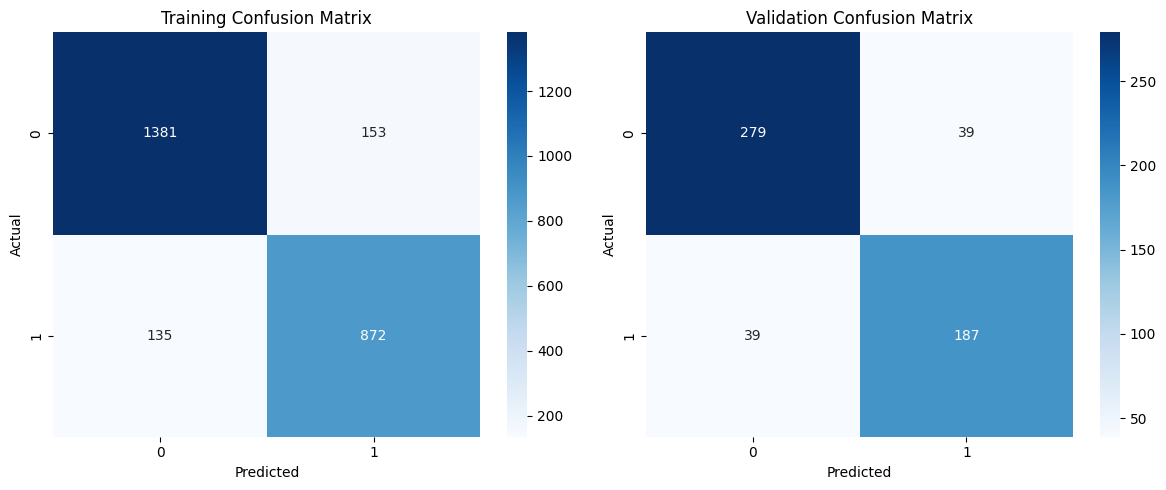

======Training Metrics======

Training Final Loss = 0.3178
Training Accuracy = 0.8867
Training Precision = 0.8507
Training Recall = 0.8659
Training f1_score = 0.8583
Training ROC_AUC = 0.9490


======Validation Metrics======

Validation Final Loss = 0.4195
Validation Accuracy = 0.8566
Validation Precision = 0.8274
Validation Recall = 0.8274
Validation f1_score = 0.8274
Validation ROC_AUC = 0.9088




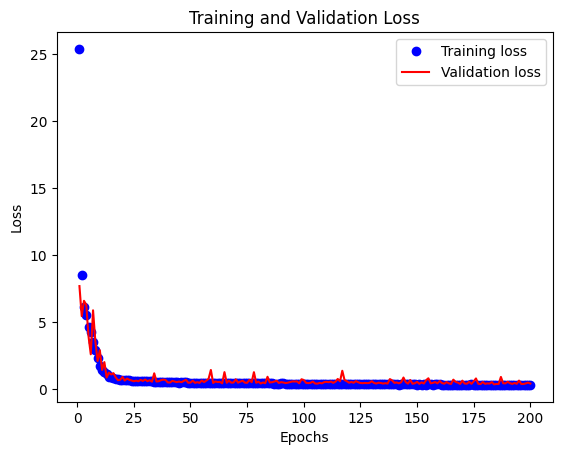

In [48]:
# Model 1 with no specified optimization techniques, dropout, regularization
model_1, epochs_1, train_loss_1, val_loss_1 = define_model(
    X_train, y_train, X_val, y_val,
    layer_1=64,
    layer_2=32,
    layer_3=16,
    batch_size=32,
    epochs=200
)
loss_curve_plot(epochs_1,train_loss_1, val_loss_1)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


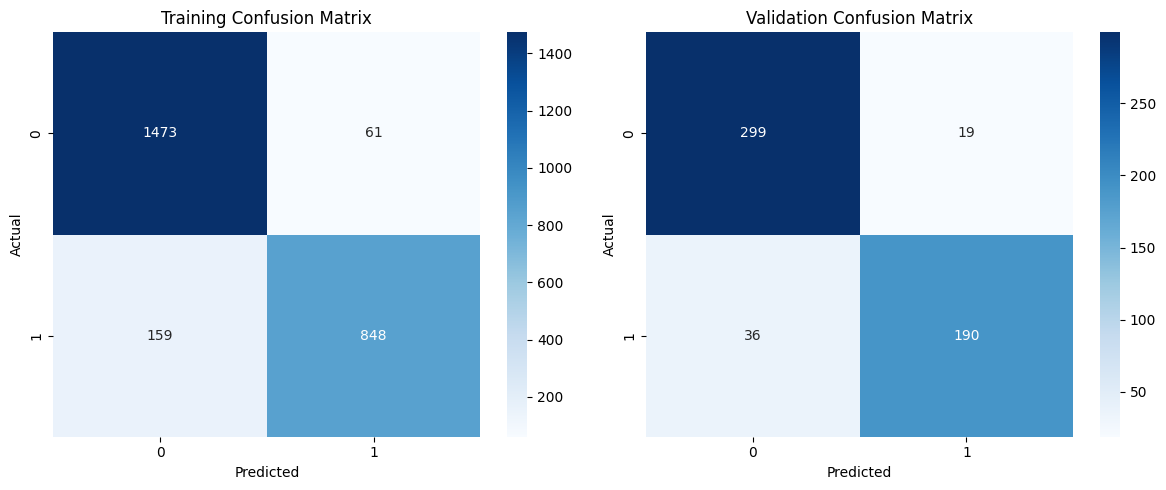

======Training Metrics======

Training Final Loss = 0.2265
Training Accuracy = 0.9134
Training Precision = 0.9329
Training Recall = 0.8421
Training f1_score = 0.8852
Training ROC_AUC = 0.9625


======Validation Metrics======

Validation Final Loss = 0.3191
Validation Accuracy = 0.8989
Validation Precision = 0.9091
Validation Recall = 0.8407
Validation f1_score = 0.8736
Validation ROC_AUC = 0.9418




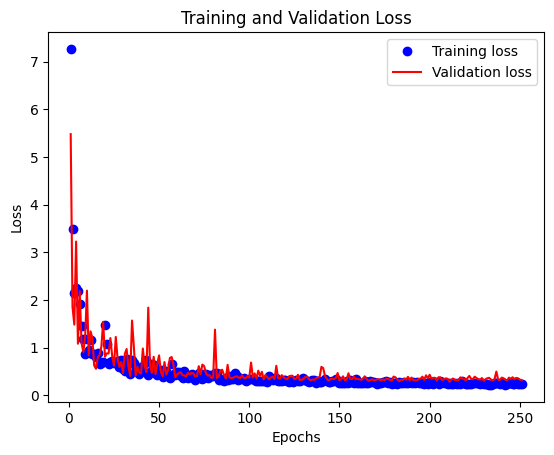

In [50]:
#TODO:
# Model 2 change from default to adam optimizer, retain nn structure, increase epochs,add early stopping, and increase neurons no dropout or regularization just yet.
model_2, epochs_2, train_loss_2, val_loss_2 = define_model(X_train, y_train, X_val, y_val, optimizer='adam', learning_rate=0.001, layer_1=128, layer_2=64, layer_3=32, batch_size=32, epochs=350, early_stopping=True)
loss_curve_plot(epochs_2, train_loss_2, val_loss_2)
# print out confusion matrix and error analysis metrics after the cell

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


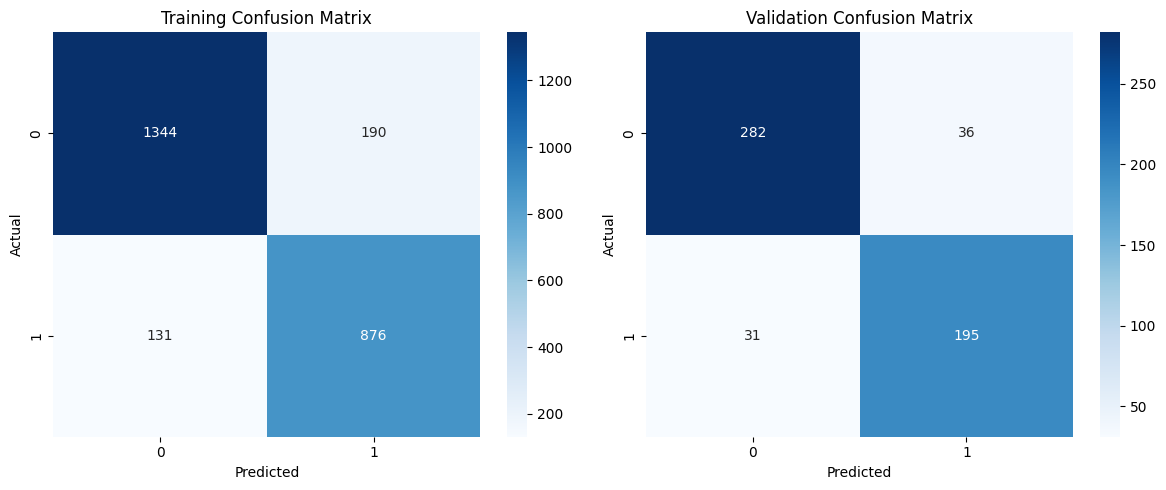

======Training Metrics======

Training Final Loss = 0.4369
Training Accuracy = 0.8737
Training Precision = 0.8218
Training Recall = 0.8699
Training f1_score = 0.8452
Training ROC_AUC = 0.9360


======Validation Metrics======

Validation Final Loss = 0.4466
Validation Accuracy = 0.8768
Validation Precision = 0.8442
Validation Recall = 0.8628
Validation f1_score = 0.8534
Validation ROC_AUC = 0.9285




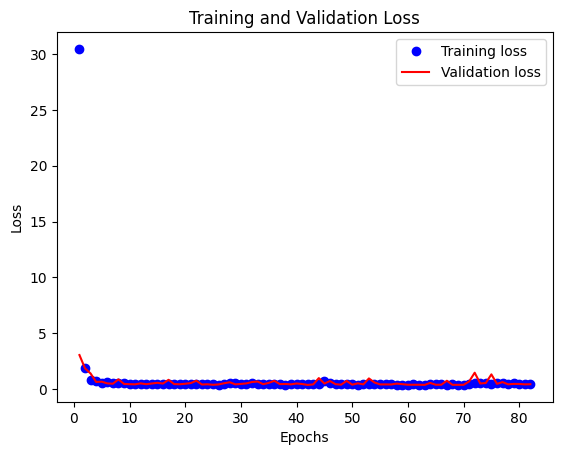

In [51]:
# Still on adam optimizer, add weak l2 regularization to attempt to reduce slight overfitting, increase learning rate,  no dropout yet, increase epochs to 400,
model_3, epochs_3, train_loss_3, val_loss_3 = define_model(X_train, y_train, X_val, y_val, optimizer='adam', learning_rate=0.01,
regularization_type='l2', regularization_strength=0.00001,
layer_1=128, layer_2=64, layer_3=32,
batch_size=32, epochs=400, early_stopping=True)
loss_curve_plot(epochs_3, train_loss_3, val_loss_3)

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


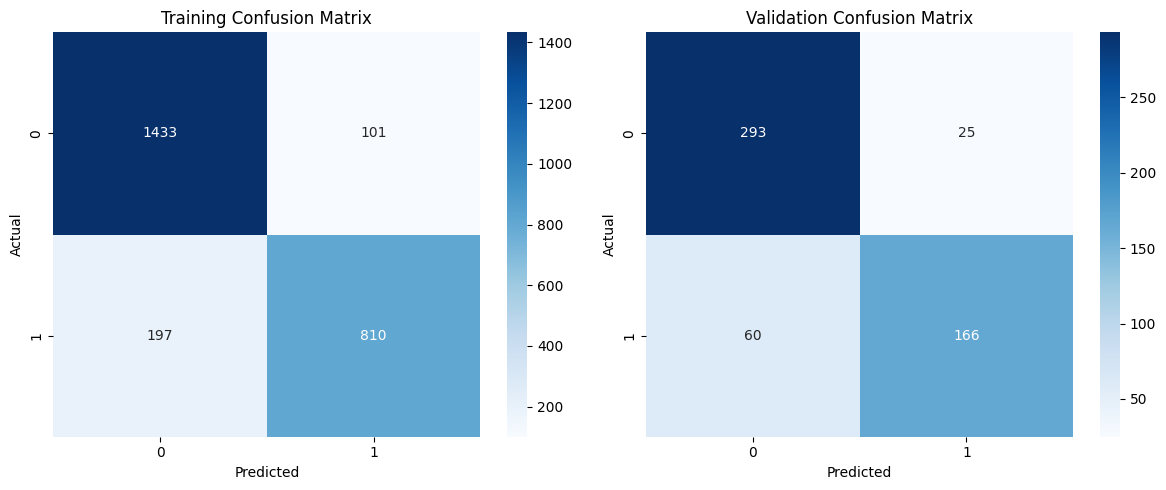

======Training Metrics======

Training Final Loss = 0.3712
Training Accuracy = 0.8827
Training Precision = 0.8891
Training Recall = 0.8044
Training f1_score = 0.8446
Training ROC_AUC = 0.9452


======Validation Metrics======

Validation Final Loss = 0.5019
Validation Accuracy = 0.8438
Validation Precision = 0.8691
Validation Recall = 0.7345
Validation f1_score = 0.7962
Validation ROC_AUC = 0.9073




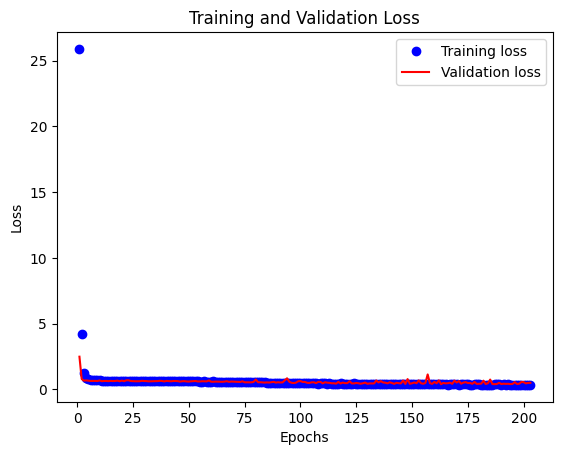

In [52]:
#TODO:
# switch optimizer to rmsprop, add minimal dropout, switch t0
model_4, epochs_4, train_loss_4, val_loss_4  = define_model(X_train, y_train, X_val, y_val, optimizer='rmsprop', learning_rate=0.001, regularization_type='l2', regularization_strength=0.00001, dropout=0.05, layer_1=128, layer_2=64, layer_3=32, batch_size=32, epochs=400, early_stopping=True)
loss_curve_plot(epochs_4, train_loss_4, val_loss_4)
#print out confusion matrix and error analysis metrics after the cell

80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


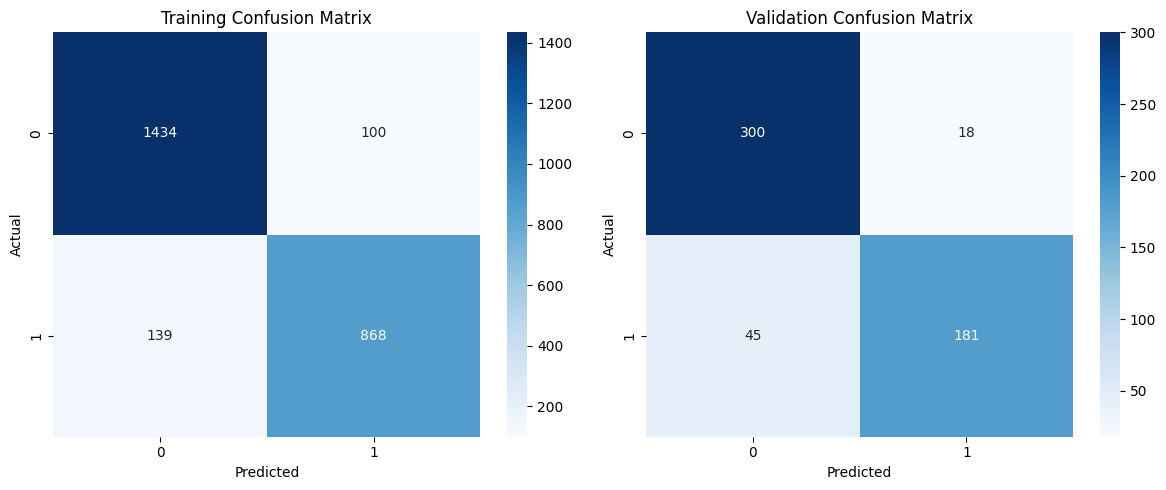

======Training Metrics======

Training Final Loss = 0.3063
Training Accuracy = 0.9059
Training Precision = 0.8967
Training Recall = 0.8620
Training f1_score = 0.8790
Training ROC_AUC = 0.9593


======Validation Metrics======

Validation Final Loss = 0.3653
Validation Accuracy = 0.8842
Validation Precision = 0.9095
Validation Recall = 0.8009
Validation f1_score = 0.8518
Validation ROC_AUC = 0.9293




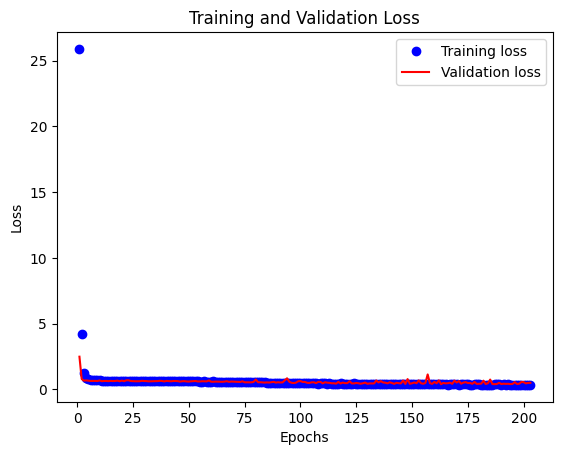

In [53]:
#TODO:
model_5, epochs_5, train_loss_5, val_loss_5  = define_model(X_train, y_train, X_val, y_val, optimizer='rmsprop', learning_rate=0.001, regularization_type='l1', regularization_strength=0.00001, dropout=0.05, layer_1=256, layer_2=128, layer_3=64, batch_size=32, epochs=400, early_stopping=True)
loss_curve_plot(epochs_4, train_loss_4, val_loss_4)
#print out confusion matrix and error analysis metrics after the cell

#Task: Make Predictions using the best saved model


Create a confusion Matrix and F1 score for both Models. Ensure outputs for the cells are visible

Finally, Make predictions using the best model. By the time you get to this cell you may realise at some point you needed to save the model so that you cal load it later

In [54]:
import os
import joblib  # For saving sklearn models like RandomForest

# Create the saved_models directory if it doesn't exist
os.makedirs('saved_models', exist_ok=True)

# Save Neural Network Models (assuming they're named model_1, model_2, etc.)
models = [model_1, model_2, model_3, model_4, model_5]
model_names = ['model_1', 'model_2', 'model_3', 'model_4', 'model_5']

for model, name in zip(models, model_names):
    save_path = os.path.join('saved_models', f'{name}.keras')
    model.save(save_path)
    print(f"✅ Saved {name} to {save_path}")

# Save RandomForest models
rf_model = [rf_model]  # Add all your RF models here
rf_name = ['random_forest_model']  # Adjust names as needed

for rf_model, name in zip(rf_model, rf_name):
    save_path = os.path.join('saved_models', f'{name}.pkl')
    joblib.dump(rf_model, save_path)
    print(f"✅ Saved {name} to {save_path}")

# List all saved files
print("\n📁 Saved files:")
for file in os.listdir('saved_models'):
    file_path = os.path.join('saved_models', file)
    file_size = os.path.getsize(file_path) / (1024*1024)  # Size in MB
    print(f"   {file} ({file_size:.2f} MB)")

✅ Saved model_1 to saved_models/model_1.keras
✅ Saved model_2 to saved_models/model_2.keras
✅ Saved model_3 to saved_models/model_3.keras
✅ Saved model_4 to saved_models/model_4.keras
✅ Saved model_5 to saved_models/model_5.keras
✅ Saved random_forest_model to saved_models/random_forest_model.pkl

📁 Saved files:
   random_forest_model.pkl (9.08 MB)
   model_4.keras (0.15 MB)
   model_5.keras (0.43 MB)
   model_1.keras (0.07 MB)
   model_2.keras (0.21 MB)
   model_3.keras (0.21 MB)


In [55]:
from tensorflow.keras.models import load_model, save_model
# Save the best model
# model 3 is the best model due to having the highest recall(most important for this use case), no overfitting and resonable precision
model_3.save('best_model.keras')


In [56]:
def make_predictions(model_path, X):

    # Load the model
    model = load_model(model_path)
    # Make predictions
    predictions = model.predict(X)
    # Convert probabilities to binary labels (0 or 1)
    binary_predictions = (predictions > 0.5).astype(int)

    return binary_predictions

#Modify the code appropriately

In [58]:
model_path = 'best_model.keras'
make_predictions(model_path, X_test)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_prob)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("======Test Metrics======\n")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
======Test Metrics======

Test Accuracy: 0.8954
Test Loss: 0.3312
F1 Score: 0.8421
AUC Score: 0.9209
Recall: 0.8085
Precision: 0.8786


Congratulations!!
